# Regression uncertainties

In the previous notebook we discussed how to fit data to a neural network. Now, let's try to add uncertainties to it.

We are going to use the `torchbnn` module for that, so that we do not have to go into the details of how everything is implemented.


In [1]:
from typing import Tuple

# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchbnn as bnn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d


We start as before: generating the same dataset, which is simple enough that we can visualize the results easily.

$f(x) = (3 + \kappa) x^2 + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu=0, \sigma=10)$ and $\kappa \sim \mathcal{N}(\mu=0, \sigma=0.03)$.

In this case we do know the true model, so it is interesting to take some time to pinpoint the role of $\kappa$ and $\epsilon$. These variables add fluctuation to the results. $\epsilon$ adds Gaussian noise in a way that is completely independent from $x$ and cannot be traced down to a particular functional dependence. $\kappa$ changes a specific parameter of the model, in this case the coefficient 3, by around 1%.

When fitting a model, the nomenclature *epistemic uncertainty* is often used to refer to uncertainties coming to effects related to different functional models. That is, one can imagine that there are different functions that may fit the data due to the effect of $\kappa$, such as: $g(x) = 3x^2$ or $h(x) = 2.95x^2$.

The nomenclature *aleatoric uncertainty* is used to refer to whichever uncertainty cannot be tracked down to a given model dependence. In this example, different constant factors could be added to the model $g$ to account for the fluctuations in $\epsilon$.


In [2]:
def generate_data(N: int) -> np.ndarray:
    x = 2*np.random.randn(N, 1)
    epsilon = 10*np.random.randn(N, 1)
    kappa = 0.03*np.random.randn(N, 1)
    z = (3 + kappa)*x**2 + epsilon
    return np.concatenate((x, z), axis=1).astype(np.float32)

train_data = generate_data(N=1000)

PyTorch allows you to create a class that outputs a single data entry and use that to feed input to your neural network. We will use the following class to feed the data to the neural network. This looks useless if all your data fits in a Numpy array, but notice that if you have a lot of data and cannot load it all in memory, this allows you to read data on demand, as you need it and only the needed samples are stored at a single time.

In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data: np.ndarray):
        self.data = data
    def __len__(self) -> int:
        """How many samples do I have?"""
        return len(self.data)
    def __getitem__(self, idx):
        # give me item with index idx
        return {"data": self.data[idx, 0:1], "target": self.data[idx, 1:]}


In [4]:
my_dataset = MyDataset(train_data)
print(len(my_dataset))

1000


In [5]:
print(my_dataset[1])

{'data': array([3.1168816], dtype=float32), 'target': array([24.181654], dtype=float32)}


## Let's add uncertainties

The method shown before finds the neural network parameters which maximize the log-likelihood of the data. But not all parameters are equally likely and we can estimate an uncertainty for them.

With an uncertainty for the parameters, we can propagate the uncertainty through the neural network and obtain an uncertainty on the prediction of the regression output.

This can be done assuming each weight in the network function has a given probability distribution and instead of fitting a single value for the weight, we fit the parameters of this probability distribution. For the example shown here, we assume that the probability distribution of the weights is Gaussian and we aim to obtain the mean and variance of the Gaussian.

We are going to include the epistemic uncertainty through the variation of the weights. That is, the fact that the weights vary and lead to different effective functions allow us to model different $f(x)$ dependence relationships and this is attributed to the epistemic uncertainty.

We additionally assume that the data collected has some aleatoric uncertainty, which means that every point is uncertain by some fixed unknown amount. To model this effect, we assume that the likelihood function $p(\text{data}|\theta)$ can be modelled by a Gaussian distribution with a certain standard deviation $\sigma_a$. This standard deviation will be used to model the aleatoric uncertainty.

There are several ways to predict uncertainties in a model in general. The method we use here is called Variational Inference. In this method, we assume that we know to a good approximation some probability distribution for the function $f(x)$, but we don't know its exact probabilities. For example, we assume that the weights of the function are distributed according to a Gaussian and this already restricts how some functions $f(x)$ are more likely than others. The task then becomes simply how to discover which weights are more likely than others, transforming a function- and distribution-finding problem into a weights-finding problem. How do we find then the weights under this approximation?

Since we assumed we know that all weights are distributed with a Gaussian distribution, we already know that if we fix the mean value for each weight and the standard deviation of each weight, we can in principle calculate the probability distribution modelled for our network. Let us call this probability distribution $q$. We know what the true probability distribution for the weights should really be, since this comes from the Bayes theorem: 

$p(\text{weights}|\text{data}) \propto p(\text{data}|\text{weights}) p(\text{weights})$.

In this equation, $p(\text{weights})$ is Gaussian for each weight and $p(\text{data}|\text{weights})$ is the likelihood that our prediction matches data with a fixed set of weights, which we shall also assume to be Gaussian and its standard deviation shall model the aleatoric uncertainty. Now, since we know the true form of the weights distribution, given the data, we can minimize some sort of *distance* between $p(\text{weights}|\text{data})$ and $q$, which is our approximation. How can we measure distances between probability distributions? There isn't exactly an easy-to-use concept for distances here (but see this if you want to go into more advanced things: http://www.scholarpedia.org/article/Fisher-Rao_metric ), but there is a concept of *divergence* that we can easily take advantage of. Divergences do not necessarily respect the triangular inequality, so they are not interchangeable with distances, but they provide the key element that we need here: smaller divergences between $q$ and $p(\text{weights}|\text{data})$ lead to them being more similar to one another.

The divergence we shall use here is called the Kullback-Leibler divergence and it is closely related to the concept of Mutual Information and Entropy in Information Theory (which in reality "borrowed" these ideas from Statistical Mechanics). The Kullback-Leibler divergence between two distributions is defined as:

$KL(q||p) = \int q(x) \log \left(\frac{p(x)}{q(x)}\right) dx$.

If we plug in this definition of the Kullback-Leibler divergence in the analytical form of our $q$, we obtain a final number that we may choose to minimize, so that our final $p(\text{weights}|\text{data})$ is maximized. The details of this derivation can be seen here and in cited sources: https://arxiv.org/pdf/1505.05424.pdf

The final loss function obtained is:

$\mathcal{L} = -\mathbb{E}_{\text{data}}\left[\log p(\text{data}|\text{weights})\right] + \frac{1}{M} KL(\text{weights}|\text{prior})$

As mentioned, the first term is assumed to come from a Gaussian with the standard deviation given by the aleatoric uncertainty (assumed to be the same for every data point, but this could be changed to be data-point specific as well!). The second term corresponds to a penalty for varying the weights away from the prior assumption that the weights are Gaussian with a mean zero and standard deviation 0.1. In this equation, $M$ is the number of batches used.

A quick sketch from the mentioned paper showing the justification behind this equation is given below:

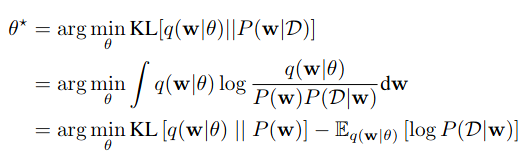


In [6]:
class BayesianNetwork(nn.Module):
    """
        A model Bayesian Neural network.
        Each weight is represented by a Gaussian with a mean and a standard deviation.
        Each evaluation of forward leads to a different choice of the weights, so running
        forward several times we can check the effect of the weights variation on the same input.
        The nll function implements the negative log likelihood to be used as the first part of the loss
        function (the second shall be the Kullback-Leibler divergence).
        The negative log-likelihood is simply the negative log likelihood of a Gaussian
        between the prediction and the true value. The standard deviation of the Gaussian is left as a
        parameter to be fit: sigma.
    """
    def __init__(self, input_dimension: int=1, output_dimension: int=1):
        super(BayesianNetwork, self).__init__()
        hidden_dimension = 100
        self.model = nn.Sequential(
                                   bnn.BayesLinear(prior_mu=0,
                                                   prior_sigma=1,
                                                   in_features=input_dimension,
                                                   out_features=hidden_dimension),
                                   nn.ReLU(),
                                   bnn.BayesLinear(prior_mu=0,
                                                   prior_sigma=1,
                                                   in_features=hidden_dimension,
                                                   out_features=hidden_dimension),
                                   nn.ReLU(),
                                   bnn.BayesLinear(prior_mu=0,
                                                   prior_sigma=1,
                                                   in_features=hidden_dimension,
                                                   out_features=output_dimension)
                                    )
        self.log_sigma2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Calculate the result f(x) applied on the input x.
        """
        return self.model(x)

    def nll(self, prediction: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Calculate the negative log-likelihood (divided by the batch size, since we take the mean).
        """
        error = prediction - target
        squared_error = error**2
        sigma2 = torch.exp(self.log_sigma2)[0]
        norm_error = 0.5*squared_error/sigma2
        norm_term = 0.5*(np.log(2*np.pi) + self.log_sigma2[0])*target.shape[1]
        return norm_error.sum(1).mean(0) + norm_term

    def aleatoric_uncertainty(self) -> torch.Tensor:
        """
            Get the aleatoric component of the uncertainty.
        """
        return torch.exp(0.5*self.log_sigma2[0])

In [7]:
# create the neural network:
b_network = BayesianNetwork()

# create the object to load the data:
B = 10
loader = torch.utils.data.DataLoader(my_dataset, batch_size=B)

# create the optimizer to be used 
optimizer = torch.optim.Adam(b_network.parameters(), lr=0.001)

# the Kullback-Leibler divergence should be scaled by 1/number_of_batches
# see https://arxiv.org/abs/1505.05424 for more information on this
number_of_batches = len(my_dataset)/float(B)
weight_kl = 1.0/float(number_of_batches)
# divide by B, because we implicitly divide by the number of sample taking the mean in the `nll` function above
weight_kl /= float(B)

/home/daniloefl/miniconda3/envs/ml/lib/python3.12/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


The criteria for finding the optimal weights are based on the Bayes' theorem, on which the posterior probability of the weights is proportional to the likelihood of the data given the weights and to the prior probability of the weights. We assume the prior probability of the weights is Gaussian corresponding to a unit Gaussian centred at zero and with standard deviation 0.1. This prior has a regularizing effect, preventing overtraining.

We can translate the Bayes theorem and the assumption that the final posterior distribution is also Gaussian into an optimization procedure to find the posterior mean and variance of the posterior distribution. The function optimized to obtain the mean and variances of the Gaussians for the weights is the sum between the mean-squared-error (corresponding to a Gaussian log-likelihood of the data) and the Kullback-Leibler divergence between the weights distribution and the prior Gaussian.

In [8]:
kl_loss = bnn.BKLLoss(reduction='sum', last_layer_only=False)

In [9]:
epochs = 500
# for each epoch
for epoch in range(epochs):
    losses = list()
    # for each mini-batch given by the loader:
    for batch in loader:
        # get the input in the mini-batch
        # this has size (B, C)
        # where B is the mini-batch size
        # C is the number of features (1 in this case)
        features = batch["data"]
        # get the targets in the mini-batch (there shall be B of them)
        target = batch["target"]
        # get the output of the neural network:
        prediction = b_network(features)
        
        # calculate the loss function being minimized
        # in this case, it is the mean-squared error between the prediction and the target values added
        # to the Kullback-Leibler divergence between the current weight Gaussian and
        # the prior Gaussian, set to the unit Normal distribution
        nll = b_network.nll(prediction, target)
        prior = weight_kl *kl_loss(b_network)
        loss = nll + prior

        # clean the optimizer temporary gradient storage
        optimizer.zero_grad()
        # calculate the gradient of the loss function as a function of the gradients
        loss.backward()
        # ask the Adam optimizer to change the parameters in the direction of - gradient
        # Adam scales the gradient by a constant which is adaptively tuned
        # take a look at the Adam paper for more details: https://arxiv.org/abs/1412.6980
        optimizer.step()
        
        ale = b_network.aleatoric_uncertainty().detach().numpy()

        losses.append(loss.detach().cpu().item())
    avg_loss = np.mean(np.array(losses))
    print(f"Epoch {epoch}/{epochs}  total: {avg_loss:.5f}, -LL: {nll.item():.5f}, prior: {prior.item():.5f}, aleatoric unc.: {ale:.5f}")

Epoch 0/500  total: 2435.83432, -LL: 1551.37427, prior: 0.04746, aleatoric unc.: 1.70531
Epoch 1/500  total: 2690.43966, -LL: 2229.10327, prior: 0.04931, aleatoric unc.: 1.76272
Epoch 2/500  total: 1526.76653, -LL: 2766.35059, prior: 0.05077, aleatoric unc.: 1.80162
Epoch 3/500  total: 1828.29339, -LL: 5460.06152, prior: 0.05248, aleatoric unc.: 1.84704
Epoch 4/500  total: 2087.77363, -LL: 141.62004, prior: 0.05498, aleatoric unc.: 1.90438
Epoch 5/500  total: 1298.08500, -LL: 283.75870, prior: 0.05674, aleatoric unc.: 1.94193
Epoch 6/500  total: 1299.54989, -LL: 438.40015, prior: 0.05896, aleatoric unc.: 1.98381
Epoch 7/500  total: 870.89555, -LL: 119.83515, prior: 0.06040, aleatoric unc.: 2.01517
Epoch 8/500  total: 914.58817, -LL: 343.38049, prior: 0.06228, aleatoric unc.: 2.04984
Epoch 9/500  total: 783.65787, -LL: 1519.52515, prior: 0.06418, aleatoric unc.: 2.08130
Epoch 10/500  total: 812.71991, -LL: 447.55548, prior: 0.06638, aleatoric unc.: 2.11806
Epoch 11/500  total: 731.69551

After the fit, each time we perform a prediction with the neural network, the weights of the neural network are different: they are randomly chosen from a Gaussian distribution with the fit mean and standard deviation. The logic here is that all these weights match the expected posterior probability optimized, so they should all provide trustworthy results given the data available (but not equally probable!).

In order to obtain an uncertainty band for each prediction, we perform each prediction with the neural network fit several times to obtain the results with different set of weights following the posterior probability mentioned. After taking several results for the same input data, we can use the mean prediction as the "nominal" prediction and the root-mean-squared-error of the predictions as the uncertainty of the prediction, given the available data.


In [10]:
# let's generate new data!
test_data = generate_data(N=1000)

b_predicted = list()
for k in range(10):
    p = b_network(torch.from_numpy(test_data[:,0:1])).detach().numpy()
    b_predicted.append(p[:,0])
b_predicted = np.stack(b_predicted, axis=1)

We can now take the average result for each sample, and their root-mean-squared-error as an estimate of the mean and epistemic uncertainty for the results.

The aleatoric uncertainty is fitted as an independent parameter. Since we assume the aleatoric uncertainty is independent, we can calculate the total uncertainty as the sum of squares of the epistemic and aleatoric uncertainty.

In [11]:
b_mean = np.mean(b_predicted, axis=1)
b_sigma = np.std(b_predicted, axis=1)
aleatoric_uncertainty = b_network.aleatoric_uncertainty().detach().numpy()

total_uncertainty = (b_sigma**2 + aleatoric_uncertainty**2)**0.5

Let's check how big are those uncertainties found:

In [12]:
print("Average epistemic uncertainty: ", np.mean(b_sigma))

Average epistemic uncertainty:  5.5692353


In [13]:
print("Aleatoric uncertainty: ", aleatoric_uncertainty)

Aleatoric uncertainty:  12.859908


Note that the aleatoric uncertainty is very close to the standard deviation of the $\epsilon$ component of the model we created in the beginning! Clearly the model could fit the uncertainty coming from that component of the noise.

It is not easy to estimate the effect of the epistemic uncertainty, as it is different for every data point (as it is scaled by $x^2$), but we can plot it to take a look at its effect.

Note that the uncertainties are the standard deviations of Gaussian models and therefore they correspond to a $1\sigma$ quantile band, which is a 67% confidence band. The quantile corresponding to $2\sigma$ corresponds to a 95% confidence band in a Gaussian model.

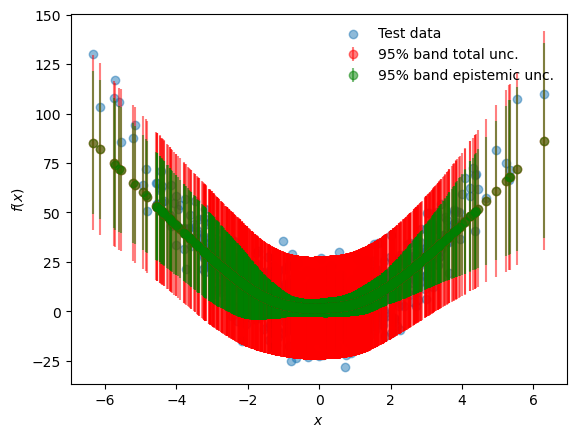

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(test_data[:, 0], test_data[:, 1], alpha=0.5, label="Test data")
ax.errorbar(test_data[:, 0], b_mean, yerr=2*total_uncertainty, alpha=0.5, fmt='or', label="95% band total unc.")
ax.errorbar(test_data[:, 0], b_mean, yerr=2*b_sigma, alpha=0.5, fmt='og', label="95% band epistemic unc.")
ax.set(xlabel="$x$", ylabel="$f(x)$")
#ax.set_yscale('log')
plt.legend(frameon=False)
plt.show()